In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [20]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [21]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states, steps=steps)

In [22]:
cache_states = [0, 33, 66]

# Run Task (with learning)

In [23]:
model.reset()
cache_acts = []
cache_acts_over_time = []
retrieval_acts_over_time = []

for cache_state in cache_states:
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    cache_acts.append(acts.copy())
    cache_acts_over_time.append(acts_over_time.copy())

Now I just cached at location: 0
Now I just cached at location: 33
Now I just cached at location: 66


In [24]:
_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_acts, axis=0).flatten()
place_std = np.std(place_acts, axis=0).flatten()

# Define cache activity as a mean over some time window

In [25]:
start_t = steps-25 # Start of time window

In [26]:
avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = cache_acts_over_time[i][start_t:steps, location, :].mean(axis=0)
    avg_cache_acts.append(vec)
avg_cache_acts = np.array(avg_cache_acts)

In [27]:
cache_mean = avg_cache_acts.mean(axis=0)

# Define seed vector

In [28]:
# Defined as J_sx
seed_vec = model.J_sx.copy()
seed_vec /= np.linalg.norm(seed_vec)

In [29]:
# Defined as occupied/unoccupied difference
occupied = []
unoccupied = []
_, _check_acts, _, _check_acts_over_time = model.run_recall(
    0.2, place_inputs)
for c in range(num_states):
    if c in cache_states: # occupied
        occupied.append(_check_acts_over_time[:steps,c].mean(axis=0))
    elif min([distance(c, _c, num_states) for _c in cache_states]) < 5:
        continue
    else: # unoccupied
        unoccupied.append(_check_acts_over_time[start_t:steps,c].mean(axis=0))
occupied = np.array(occupied).mean(0)
unoccupied = np.array(unoccupied).mean(0)
seed_vec = occupied - unoccupied
seed_vec /= np.linalg.norm(seed_vec)

# Actual retrieval time course
_, _check_acts, _, _check_acts_over_time = model.run_recall(
    0.2, place_inputs)

# Fig 7: Projections in time

In [30]:
barcodes = []
for i in range(len(cache_states)):
    location = cache_states[i]
    
    # Cache activations
    _cache_act = avg_cache_acts[i].copy()
    _cache_act -= cache_mean
    
    # Place activations
    _place_act = place_acts[location].copy()
    _place_act -= place_mean
    _place_act /= np.linalg.norm(_place_act)
    
    # Define barcode
    projection = np.dot(_cache_act, _place_act) * _place_act
    barcode = _cache_act - projection
    barcodes.append(barcode)
barcodes = np.array(barcodes)

In [31]:
barcodes /= np.linalg.norm(barcodes, axis=1)[:,None]

In [32]:
locations = []
place_proj_in_time = []
barcode_proj_in_time = []
seed_proj_in_time = []

for i in range(len(cache_states)):
    location = cache_states[i]
    _cache_act_over_time = cache_acts_over_time[i]
    
    # Cache activations
    _cache_act = avg_cache_acts[i].copy()
    _cache_act -= cache_mean
    
    # Place activations
    _place_act = place_acts[location].copy()
    _place_act -= place_mean
    _place_act /= np.linalg.norm(_place_act)
    
    # Over time
    _place_proj_in_time = []
    _barcode_proj_in_time = []
    _seed_proj_in_time = []
    for t in range(_cache_act_over_time.shape[0]):
        _c = _cache_act_over_time[t][location] # (n_units,)
        _place_proj_in_time.append(np.dot(_c, _place_act))
        _barcode_proj_in_time.append(np.dot(_c, barcodes[i]))
        _seed_proj_in_time.append(np.dot(_c, seed_vec))
    place_proj_in_time.append(_place_proj_in_time)
    barcode_proj_in_time.append(_barcode_proj_in_time)
    seed_proj_in_time.append(_seed_proj_in_time)

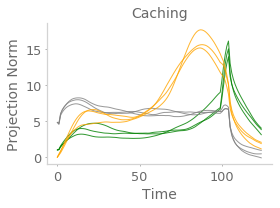

In [33]:
# Chettih et al Figure 7
plt.figure(figsize=(4,3))
for sp in seed_proj_in_time:
    plt.plot(sp, alpha=0.8, color='green')
for pp in place_proj_in_time:
    plt.plot(pp, alpha=0.8, color='gray')
for bp in barcode_proj_in_time:
    plt.plot(bp, alpha=0.8, color='orange')
plt.xlabel('Time')
plt.ylabel('Projection Norm')
plt.title('Caching')
plt.tight_layout()
plt.savefig('temp_spacing.png', dpi=300)
plt.show()

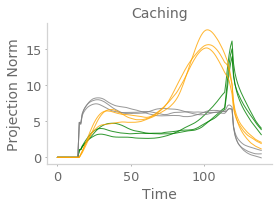

In [34]:
# Chettih et al Figure 7
plt.figure(figsize=(4,3))
for sp in seed_proj_in_time:
    plt.plot([0]*15 + sp, alpha=0.8, color='green')
for pp in place_proj_in_time:
    plt.plot([0]*15 + pp, alpha=0.8, color='gray')
for bp in barcode_proj_in_time:
    plt.plot([0]*15 + bp, alpha=0.8, color='orange')
plt.xlabel('Time')
plt.ylabel('Projection Norm')
plt.title('Caching')
plt.tight_layout()
plt.savefig('temp_spacing_0pad.png', dpi=300)
plt.show()

# Retrieval Projections

In [16]:
place_proj_in_time = []
barcode_proj_in_time = []
seed_proj_in_time = []
for i in range(len(cache_states)):
    location = cache_states[i]
    
    # Place activations
    _place_act = place_acts[location].copy()
    _place_act -= place_mean
    _place_act /= np.linalg.norm(_place_act)
    
    _ret_acts_over_time = _check_acts_over_time[:,location,:]
    
    # Over time
    _place_proj_in_time = []
    _barcode_proj_in_time = []
    _seed_proj_in_time = []
    for t in range(_check_acts_over_time.shape[0]):
        _c = _ret_acts_over_time[t] # (n_units,)
        _place_proj_in_time.append(np.dot(_c, _place_act))
        _barcode_proj_in_time.append(np.dot(_c, barcodes[i]))
        _seed_proj_in_time.append(np.dot(_c, seed_vec))
    place_proj_in_time.append(_place_proj_in_time)
    barcode_proj_in_time.append(_barcode_proj_in_time)
    seed_proj_in_time.append(_seed_proj_in_time)

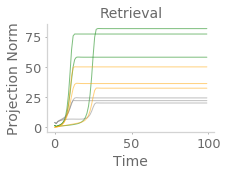

In [17]:
# Chettih et al Figure 7
plt.figure(figsize=(3,2))
for sp in seed_proj_in_time:
    plt.plot(sp, alpha=0.5, color='green')
for pp in place_proj_in_time:
    plt.plot(pp, alpha=0.5, color='gray')
for bp in barcode_proj_in_time:
    plt.plot(bp, alpha=0.5, color='orange')
plt.xlabel('Time')
plt.ylabel('Projection Norm')
plt.title('Retrieval')
plt.show()

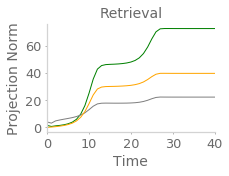

In [18]:
# Chettih et al Figure 7
plt.figure(figsize=(3,2))
plt.plot(np.array(seed_proj_in_time).mean(axis=0), color='green')
plt.plot(np.array(place_proj_in_time).mean(axis=0), color='gray')
plt.plot(np.array(barcode_proj_in_time).mean(axis=0), color='orange')
plt.xlim(0,40)
plt.xlabel('Time')
plt.ylabel('Projection Norm')
plt.title('Retrieval')
plt.show()